In [1]:
# Defining function to load gpx data into dataframe with some processing using the harvesine equation
import gpxpy
import pandas as pd
from haversine import haversine

def gpx_to_dataframe(file_name):
    """
    Parses a GPX file and returns a Pandas DataFrame with extracted data.
    
    Args:
        file_name (str): The path to the GPX file.
        
    Returns:
        pd.DataFrame: A DataFrame containing latitude, longitude, elevation, time,
                      and other optional GPX fields.
    """
    # Open and parse the GPX file
    with open(file_name, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Extract data from tracks (you can also extract waypoints, routes, etc.)
    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            print('Points to read:',len(segment.points))
            for i, point in enumerate(segment.points):
                
                if i==0:
                    prev_point = point
                    dist_delta = 0
                    total_dist = 0
                else:
                    dist_delta = haversine(
                        (prev_point.latitude, prev_point.longitude),
                        (point.latitude, point.longitude)
                    )
                    # Overwriting prev_point for next iteration loop
                    prev_point = point 
                    total_dist = data[-1]['total_distance'] + dist_delta

                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'total_distance': total_dist,
                    'distance_delta': dist_delta
                })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Calculate grade
    df['grade'] = (df['elevation'].diff()/df['distance_delta']/10).clip(upper=100, lower=-100)
    window_size = 5
    df['grade_MA'] = df['grade'].rolling(window=window_size).apply(
        lambda x: weighted_moving_average(x, df['distance_delta'].iloc[x.index]), raw=False)

    
    # Calculate totals
    df['total_elevation_gain'] = df['elevation'].diff().cumsum()
    df['total_ascent'] = df['elevation'].diff().clip(lower=0).cumsum()
    df['total_descent'] = df['elevation'].diff().clip(upper=0).cumsum()*(-1)
    df = df.fillna(0)
    
    return df

# Example usage:
# df = gpx_to_dataframe('your_file.gpx')
# print(df.head())

# Calculate the weighted moving average
def weighted_moving_average(x, weights):
    return (x * weights).sum() / weights.sum()


# Function to convert decimal time to mm:ss format
def decimal_to_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    minutes, seconds = divmod(total_seconds, 60)  # Get minutes and seconds
    return f"{int(minutes):02d}:{int(seconds):02d}"  # Format as mm:ss

# Function to convert decimal time to hh:mm:ss format
def decimal_to_hh_mm_ss(decimal_time):
    total_seconds = decimal_time * 60  # Convert minutes to total seconds
    hours, minutes_tmp = divmod(total_seconds, 3600)
    minutes, seconds = divmod(minutes_tmp, 60)  # Get minutes and seconds
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"  # Format as hh:mm:ss

In [2]:
# Here calculate elevation gain and loss for each KM and check predicted split times
import numpy as np
def full_df_to_km_splits(df_full, target_GAP):
    cols = ['total_distance','total_ascent','total_descent']
    df_km_splits = pd.DataFrame(columns = cols)


    split_kms = df_full['total_distance'].round().unique()

    if split_kms[-1:] < df_full['total_distance'].max():
        split_kms = np.append(split_kms,df_full['total_distance'].max().round(1))

    # Loop to get closest km indices
    for i in split_kms:
        idx_tmp = abs(df_full['total_distance']-i).idxmin()
        tmp = df_full.loc[idx_tmp,cols]
        df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)

    df_km_splits['total_distance'] = df_km_splits['total_distance'].round(1)
    df_km_splits['split_ascent'] = df_km_splits['total_ascent'].diff()
    df_km_splits['split_descent'] = df_km_splits['total_descent'].diff()
    df_km_splits = df_km_splits.drop(index=0)
    

    # Calculate predicted split time
    df_km_splits['target_pace'] = (1+df_km_splits['split_ascent']/100)*target_GAP
    df_km_splits['target_pace_mm_ss'] = df_km_splits['target_pace'].apply(decimal_to_mm_ss)

    # Calculate total time --> Work-around for last element required
    df_km_splits['total_time'] = df_km_splits['target_pace'].cumsum()
    df_km_splits.loc[df_km_splits.index[-1],'total_time'] = (df_km_splits['target_pace'].tail(1).iloc[0]
                              *round(df_km_splits['total_distance'].max() % 1,1)
                              +df_km_splits['total_time'].tail(2).iloc[0])
    df_km_splits['total_time_hh_mm_ss'] = df_km_splits['total_time'].apply(decimal_to_hh_mm_ss)

    return df_km_splits


In [3]:
df_full_70k = gpx_to_dataframe('gpx_files/COURSE_297020644.gpx')
df_full_T50 = gpx_to_dataframe('gpx_files/Transylvania_50k.gpx')

Points to read: 9350
Points to read: 32049


In [43]:
cols = ['total_distance','split_ascent','split_descent','target_pace_mm_ss']

print(df_splits_70k[cols].to_markdown(index=False))
#for i in range(len(df_splits_70k[cols])):
    #df_splits_70k[cols].iloc[i]

|   total_distance |   split_ascent |   split_descent | target_pace_mm_ss   |
|-----------------:|---------------:|----------------:|:--------------------|
|              1   |          25.89 |           30.83 | 07:33               |
|              2   |          27.28 |            2.74 | 07:38               |
|              3   |          36.29 |            2.01 | 08:10               |
|              4   |          94.54 |            0    | 11:40               |
|              5   |          47.27 |           38.26 | 08:50               |
|              6   |         147.74 |            0    | 14:51               |
|              7   |          33.21 |           15.22 | 07:59               |
|              8   |          23.12 |           63.58 | 07:23               |
|              9   |          41.32 |            2.15 | 08:28               |
|             10   |           1.62 |           34.29 | 06:05               |
|             11   |           0    |          101.42 | 06:00   

In [5]:
target_GAP = 6 # min/km
df_splits_70k = full_df_to_km_splits(df_full_70k, target_GAP)
df_splits_T50 = full_df_to_km_splits(df_full_T50, target_GAP)

C:\Users\kraus\AppData\Local\Temp\ipykernel_2656\697992531.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)
C:\Users\kraus\AppData\Local\Temp\ipykernel_2656\697992531.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_km_splits = pd.concat([df_km_splits, pd.DataFrame([tmp])], ignore_index = True)


In [6]:
df_splits_70k

,total_distance,total_ascent,total_descent,split_ascent,split_descent,target_pace,target_pace_mm_ss,total_time,total_time_hh_mm_ss
1,1.0,25.89,30.83,25.89,30.83,7.5534,07:33,7.55340,00:07:33
2,2.0,53.17,33.57,27.28,2.74,7.6368,07:38,15.19020,00:15:11
3,3.0,89.46,35.58,36.29,2.01,8.1774,08:10,23.36760,00:23:22
4,4.0,184.00,35.58,94.54,0.00,11.6724,11:40,35.04000,00:35:02
5,5.0,231.27,73.84,47.27,38.26,8.8362,08:50,43.87620,00:43:52
...,...,...,...,...,...,...,...,...,...
70,70.0,2730.68,2534.95,26.91,27.97,7.6146,07:36,583.84080,09:43:50
71,71.0,2730.68,2642.78,0.00,107.83,6.0000,06:00,589.84080,09:49:50
72,72.0,2730.68,2733.39,0.00,90.61,6.0000,06:00,595.84080,09:55:50
73,73.0,2766.64,2739.44,35.96,6.05,8.1576,08:09,603.99840,10:03:59


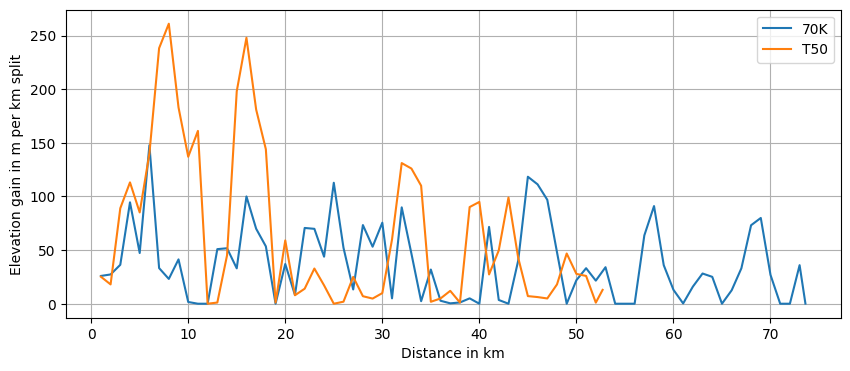

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_splits_70k.total_distance, df_splits_70k.split_ascent)
plt.plot(df_splits_T50.total_distance, df_splits_T50.split_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation gain in m per km split')
plt.legend(['70K','T50'])

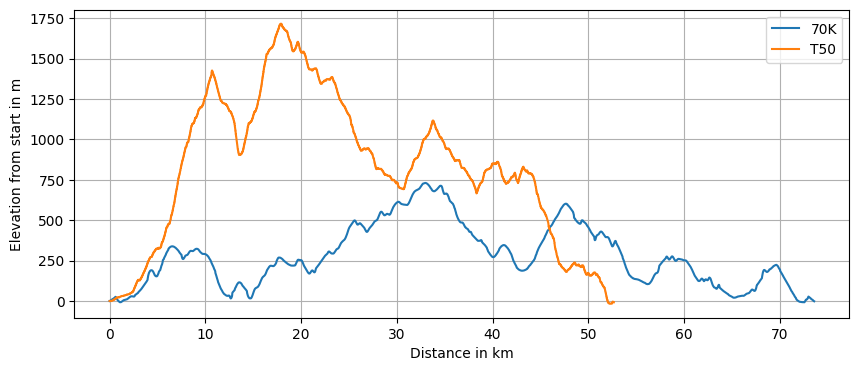

In [22]:
plt.figure(figsize=(10,4))
plt.plot(df_full_70k.total_distance, df_full_70k.total_elevation_gain)
plt.plot(df_full_T50.total_distance, df_full_T50.total_elevation_gain)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Elevation from start in m')
plt.legend(['70K','T50'])

Text(0, 0.5, 'Total Time in minutes')

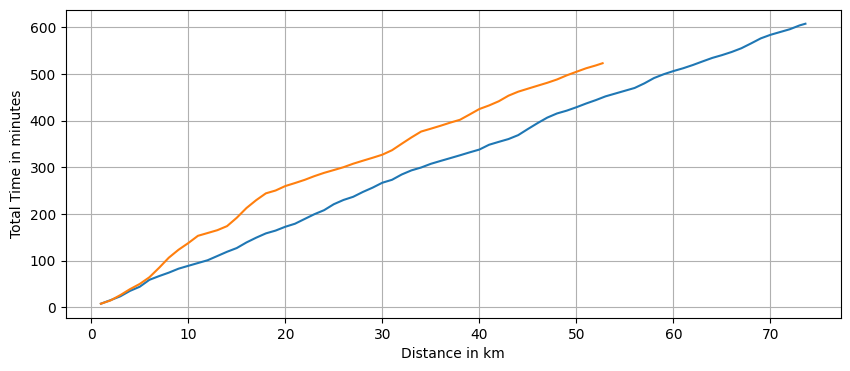

In [20]:
plt.figure(figsize=(10,4))
plt.plot(df_splits_70k.total_distance, df_splits_70k.total_time)
plt.plot(df_splits_T50.total_distance, df_splits_T50.total_time)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Total predicted time in minutes')

Text(0, 0.5, 'Total ascent in m')

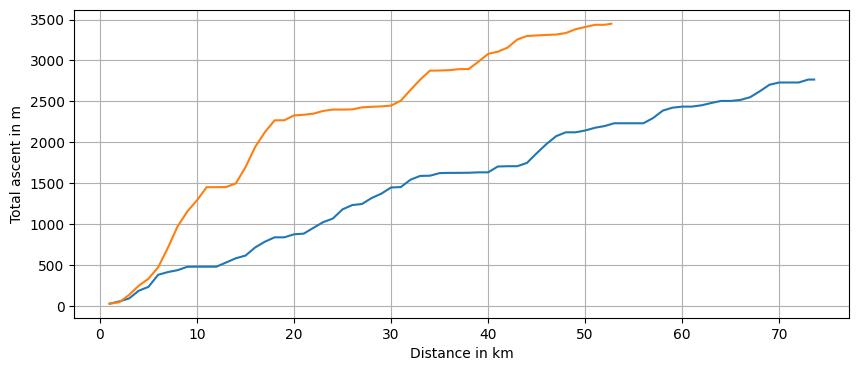

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df_splits_70k.total_distance, df_splits_70k.total_ascent)
plt.plot(df_splits_T50.total_distance, df_splits_T50.total_ascent)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Total ascent in m')

Text(0, 0.5, 'Estimated split time in minutes')

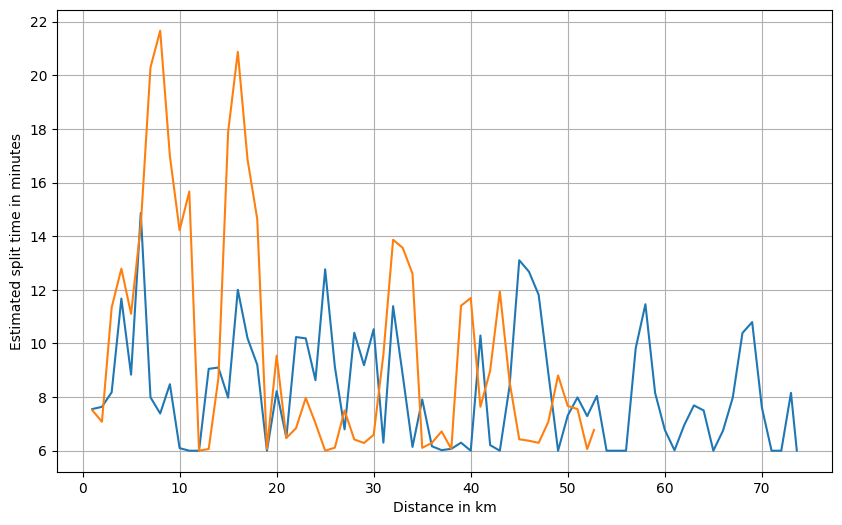

In [23]:
plt.figure(figsize=(10,6))
plt.plot(df_splits_70k.total_distance, df_splits_70k.target_pace)
plt.plot(df_splits_T50.total_distance, df_splits_T50.target_pace)
plt.grid(True)
plt.xlabel('Distance in km')
plt.ylabel('Estimated split time in minutes')